### Project 3: Plausible Utopia 

### Classification Modeling on Subreddits to Classify Futurists vs. Scientists

### Notebook 1 of 3: Preprocessing, EDA 

# To dos:

* Feature selection: 

    * Wrappers / filters / embedded methods, etc: https://en.wikipedia.org/wiki/Feature_selection
    

* Get a handle on correlation of features to target and collinearity among features
    * Check coefficients

### Problem statement

Enthralled as I am with the future, high-flying visions of art merging with technology that bring about utopia seem  ungrounded and unscientific.

Using classification models on datasets collected from the [`futurology`](https://www.reddit.com/r/Futurology) and [`science`](https://www.reddit.com/r/Science) subreddits, I'd like to answer some of the below questions (where possible):

* Are the futurist and scientist communities mutually exclusive? 

* What is the nature of the discussions amongst the scientist community?

* What is the nature of the discussions amongst the futurist community?

* Where is there topical crossover between these discussions, if any? 

* Does the topical crossover support any of the visions of the future held and propagated by futurists, such as:
  
     * Mind uploading, digital heaven, etc.
     * Reverse-aging, insect-based diets, colonization of other planets, etc.

* Furthermore, are solutions being discussed to the disaster-visions of futurists, such as:
    * Food and water shortages
    * Environmental disasters



#### Libary imports

In [395]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn import metrics
import statsmodels.api as sm
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, classification_report, accuracy_score, roc_auc_score
from sklearn.naive_bayes import MultinomialNB
     
from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import re
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import string


import warnings; warnings.simplefilter('ignore')
##this will hide deprecation/future warnings

from IPython.display import Markdown, display
pd.set_option('display.max_row', 200) # Set ipython's max row display
pd.set_option('display.max_columns', 85) # Set iPython's max column count
pd.set_option('display.max_colwidth', 1_000) # Set iPython's max column width

# pseudo-markdown in code cells
def printmd(string):
    display(Markdown(string))
# ref: https://discuss.analyticsvidhya.com/t/how-to-make-a-text-bold-within-print-statement-in-ipython-notebook/14552/2

#### Data collection

I utilized the Python Reddit API Wrapper (PRAW) API in the data collection process. You can find the steps I took in the `PRAW_data_collection` notebook, located in the code folder of this repository.

The East Coast local instructors were very generous with their walkthrough of the process, so I definitely credit them for the ease of the data collection.

From the [rubric](https://git.generalassemb.ly/abishop17/project_3/blob/master/README.md):

>Was data collection and storage optimized through custom functions, pipelines, and/or automation? <br><br>
>Was thought given to the server receiving the requests such as considering number of requests per second?

#### Preprocessing and EDA

#### Dataset 1: "New" flavor, pulled from Reddit on 10/13/20

In [396]:
subred = pd.read_csv('../data/df_with_both_subs.csv')
subred = subred.drop(columns = 'Unnamed: 0')
display(pd.set_option('display.max_colwidth', 50), subred.head())

None

,title,score,id,url,comms_num,created,body,subreddit
0,What would the point be to do anything if AI c...,0,japxs3,https://www.reddit.com/r/Futurology/comments/j...,4,1.602664e+09,The more I look into AI and new projects like ...,futurology
1,ELCC Explained: the Critical Renewable Energy ...,4,japq75,https://blog.ucsusa.org/mark-specht/elcc-expla...,0,1.602663e+09,NaN,futurology
2,There's a 50-50 chance we're living in a simul...,8,jaojnb,https://boingboing.net/2020/10/13/new-research...,4,1.602659e+09,NaN,futurology
3,"Eight nations sign NASA's Artemis Accords, ple...",3,jaofpy,https://www.engadget.com/nasa-artemis-accords-...,1,1.602658e+09,NaN,futurology
4,Mercedes benz AVTR - In Action,8,jaocqq,https://www.youtube.com/watch?v=ChqM3zqTREQ&ab...,0,1.602658e+09,NaN,futurology


---

### EDA

In [397]:
display(subred[['title', 'subreddit']].head(1))
display(subred[['title', 'subreddit']].tail(1))

,title,subreddit
0,What would the point be to do anything if AI c...,futurology


,title,subreddit
1799,Study finds middle-aged individuals — those bo...,science


#### Address duplicates

In [398]:
printmd('**Count of unique titles:**')
display(subred['title'].nunique())
printmd('**Count of titles before dropping duplicates:**')
display(subred['title'].count())

subred = subred.drop_duplicates()

printmd('**Count of titles after dropping duplicates:**')
subred['title'].nunique()

**Count of unique titles:**

1778

**Count of titles before dropping duplicates:**

1800

**Count of titles after dropping duplicates:**

1778

In [399]:
printmd('**Value counts:**')
display(subred['subreddit'].value_counts())

printmd('**Value counts by weight:**')
subred['subreddit'].value_counts(normalize = True)

**Value counts:**

science       931
futurology    869
Name: subreddit, dtype: int64

**Value counts by weight:**

science       0.517222
futurology    0.482778
Name: subreddit, dtype: float64

* I may want to return to the subreddits to get a bigger dataset to work with. 

* The classes are slightly unbalanced, so that will be a consideration during the preprocessing / get-more-data phase.

In [400]:
# Null body rows
printmd(f"**Only {len(subred['body'][(subred['body'].isnull()).astype(int) == 0])} non-null `body` records.**")

non_null_body = subred[['body', 'subreddit']][(subred['body'].isnull()).astype(int) == 0]

**Only 69 non-null `body` records.**

**Ignore `body` column since there are so few in the dataset.**

In [401]:
printmd('**Can we get enough content from post titles?**')

**Can we get enough content from post titles?**

---

In [402]:
display(pd.set_option('display.max_colwidth', 300), subred[['title', 'body']])

None

,title,body
0,What would the point be to do anything if AI could just do it all for us?,"The more I look into AI and new projects like GPT-3, we humans suck. Sure GPT-3 isn't on the level as a human brain, but that doesn't mean gpt-4 or gpt-5 won't be. I can already see the massive jobs loss as AI will offset more jobs than it will create. I'm just feeling a little existential cris..."
1,"ELCC Explained: the Critical Renewable Energy Concept You’ve Never Heard Of ""Now we live in a day and age where some parts of the country generate more than 30% of their electricity with variable renewables, and that number will fast approach 100% in the decades to come.""",NaN
2,"There's a 50-50 chance we're living in a simulation and here's how to find out ""the probability will increase as we develop technology enabling the creation of a simulation containing conscious beings.""",NaN
3,"Eight nations sign NASA's Artemis Accords, pledging peace on the moon ""It's a reaffirmation of the 1967 Outer Space Treaty.""",NaN
4,Mercedes benz AVTR - In Action,NaN
...,...,...
1795,Adults with positive SARS-CoV-2 test results were approximately twice as likely to have reported dining at a restaurant than were those with negative SARS-CoV-2 test results.,NaN
1796,50% of Phosphorus Lost to Erosion,NaN
1797,Motivated Helplessness in the Context of the Covid-19 Pandemic: Evidence for a Curvilinear Relationship Between Perceived Ability to Avoid the Virus and Anxiety,NaN
1798,"Political ideology may explain why despair spreads faster than hope during times of conflict, study suggests",NaN


### Remove content that may not generalize well or may be one-time uses

#### Remove punctuation

In [403]:
# This function is going to remove punctuation and make the text lower case

def remove_punctuation(text):
    lower = text.lower()  
    exclude = string.punctuation  #identifies punctuation marks
    return "".join(ch for ch in lower if ch not in exclude) 
   #this iterates through each character, if the character is not a punctuation mark it will join to the empty string
    
# ref: Heather Robinson at General Assembly :-)

subred['title'] = subred['title'].apply(remove_punctuation)

# ref: Heather Robinson at General Assembly :-)

subred['title'].head(10)

0                                                                                                                                                                                                     what would the point be to do anything if ai could just do it all for us
1    elcc explained the critical renewable energy concept you’ve never heard of now we live in a day and age where some parts of the country generate more than 30 of their electricity with variable renewables and that number will fast approach 100 in the decades to come
2                                                                          theres a 5050 chance were living in a simulation and heres how to find out the probability will increase as we develop technology enabling the creation of a simulation containing conscious beings
3                                                                                                                                                       eight nations sign nasas artemis ac

#### Regex tokenizing

In [404]:
printmd("`\D` = any character that is not a digit")
printmd("`w+` = any word character that occurs one or more times")

regexp_tokenizer = RegexpTokenizer('[\D]')

string_to_regexp = '50% of Phosphorus Lost to Erosion'
''.join(regexp_tokenizer.tokenize(string_to_regexp))

def regexp_tokenize(string):
    return ''.join(regexp_tokenizer.tokenize(string))

subred['title'] = subred['title'].apply(regexp_tokenize)
subred['title'].head()

`\D` = any character that is not a digit

`w+` = any word character that occurs one or more times

0                                                                                                                                                                                                what would the point be to do anything if ai could just do it all for us
1    elcc explained the critical renewable energy concept you’ve never heard of now we live in a day and age where some parts of the country generate more than  of their electricity with variable renewables and that number will fast approach  in the decades to come
2                                                                         theres a  chance were living in a simulation and heres how to find out the probability will increase as we develop technology enabling the creation of a simulation containing conscious beings
3                                                                                                                                                      eight nations sign nasas artemis accords pledging p

**Lemmatizing**, ***aka Soft wash***

In [405]:
# lemmatizer = WordNetLemmatizer()

# def split_and_lemmatize(string):
#     word = ''
#     for i in string.split():
#         word += lemmatizer.lemmatize(i + ' ')
#     return word

# # Lemmatize titles

# display(subred['title'].apply(split_and_lemmatize).head(1))

**Stemming**, ***aka Aggressive wash***

In [406]:
stemmer = PorterStemmer()  #instantiate stemmer

def split_and_stem(string):
    word = ""   #empty string
    string = string.split(' ') #creates list of words
    for i in string: #iterates through that list of words
        word += (stemmer.stem(i) + " ")  #stems each word and adds to empty string
    return word  #returns string with stemmed words

# Apply stemming to title 

subred['title'] = subred['title'].apply(split_and_stem)

# ref: Heather Robinson at General Assembly :-)

subred['title'].head()

0                                                                                                                                                                         what would the point be to do anyth if ai could just do it all for us 
1    elcc explain the critic renew energi concept you’v never heard of now we live in a day and age where some part of the countri gener more than  of their electr with variabl renew and that number will fast approach  in the decad to come 
2                                                                               there a  chanc were live in a simul and here how to find out the probabl will increas as we develop technolog enabl the creation of a simul contain consciou be 
3                                                                                                                                          eight nation sign nasa artemi accord pledg peac on the moon it a reaffirm of the  outer space treati 
4                                   

#### Binarize the target feature: `1` for Science, `0` for Futurology

In [407]:
# Check the balance of classes

printmd('**Balance of classes before binarizing**')
display(subred['subreddit'].value_counts())
display(subred['subreddit'].value_counts(normalize = True))

# subred['subreddit'] = subred['subreddit'].map({'science': 1, 'futurology': 0})

# printmd('**Balance of classes after binarizing (Science: 1, Futurology: 0)**')
# display(subred['subreddit'].value_counts())

**Balance of classes before binarizing**

science       931
futurology    869
Name: subreddit, dtype: int64

science       0.517222
futurology    0.482778
Name: subreddit, dtype: float64

In [408]:
subred = subred[['subreddit', 'title']]

subred.to_csv('../data/cleaned_data/cleaned_df.csv', index = False)

### Cutoff point 

#### To toggle between Option 1 (EDA)  and Option 2 (Optimal modeling) below:
**Step 1**: Click on this cell, then select the following from the Jupyter Notebook menu:  `Cell`  > `Run all above`

**Step 2**: Run the cells within each section below

**Step 3**: After running the last cell within the section, repeat `Step 1`, and go to the next section 

---

#### Set the features

In [409]:
# Set feature matrix and target variable

X = subred['title']
y = subred['subreddit']

### Implement CountVectorizer for purposes of EDA

### Preprocessing
- Remove special characters
- Tokenize
- Lemmatize / stem
- Remove stop words

In [410]:
subred = subred[['title', 'subreddit']]

### Bag of Words analysis

#### CountVectorizer

1. Count number of times a token is observed in a given subreddit post

2. Create a vector to store those counts

#### Create a document-term matrix to match up the subreddits and words

In [411]:
subred['title'] = subred['title'].apply(split_and_lemmatize)

subred_grouped_by_sub = subred[['subreddit', 'title']].groupby(by = 'subreddit').agg(lambda x: ' '.join(x))

# Create a document-term matrix

cv = CountVectorizer(
                     analyzer = 'word',
                     stop_words = 'english',
                     ngram_range = (1, 2),
                    )

subred_grouped_by_sub_new = cv.fit_transform(subred_grouped_by_sub['title'])

df_doc_term_matrix = pd.DataFrame(subred_grouped_by_sub_new.todense(), columns = cv.get_feature_names())

df_doc_term_matrix['subreddit'] = subred_grouped_by_sub.index
subreddit_col = df_doc_term_matrix.pop('subreddit')
df_doc_term_matrix.insert(0, 'subreddit', subreddit_col)

df_doc_term_matrix

# ref: https://www.analyticsvidhya.com/blog/2020/04/beginners-guide-exploratory-data-analysis-text-data/

,subreddit,aalto,aalto univers,abandon,abandon invest,abdomen,abdomen larg,aberdeen,aberdeen citi,aberdeen develop,aberr,aberr synapt,abil,abil absorb,abil academ,abil adapt,abil avoid,abil contract,abil control,abil current,abil evalu,abil fight,abil identifi,abil lemur,abil magnetorecept,abil maintain,abil mindcontrol,abil neuron,abil peopl,abil reiter,abil secret,abil wait,abl,abl attribut,abl chang,abl follow,abl hangout,abl hit,abl just,abl make,abl rewir,abnorm,...,zero,zero carbon,zero cut,zero economi,zero emiss,zero plastic,zeroavia,zeroavia complet,zeroavia conduct,zeroavia retrofit,zerocarbon,zerocarbon hous,zeroemiss,zeroemiss concept,zeroemiss flight,zeroemiss fuel,zinc,zinc zn,zip,zip code,zip star,ziplin,ziplin unit,zircon,zircon hyperson,zn,zn base,zombi,zombi fires,zombi occur,zombi storm,zone,zone estuari,zoologist,zoologist uncov,zoom,zoom algorithm,zoom lapd,αcmₚmₑ½,αcmₚmₑ½ km,μg,μg dose
0,futurology,0,0,1,1,0,0,2,1,1,0,0,4,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,5,1,0,1,1,1,1,0,0,0,...,5,2,1,1,1,0,3,1,1,1,1,1,3,1,1,1,1,1,0,0,0,1,1,1,1,1,1,4,1,1,2,1,1,0,0,2,1,1,0,0,0,0
1,science,1,1,0,0,1,1,0,0,0,1,1,16,0,1,0,1,1,1,1,1,1,1,2,1,0,1,1,0,1,1,1,3,0,1,0,0,0,0,1,1,3,...,2,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,2,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,1,2,2


#### Most common words

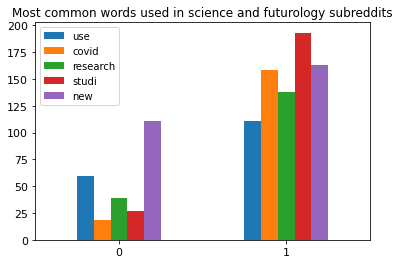

In [412]:
# Most common words used in science and futurology subreddits

top_words = df_doc_term_matrix.iloc[:, 1:].sum().sort_values(ascending = False)[:5][::-1]
top_words = df_doc_term_matrix[[word for word in pd.Series(top_words).index]]

top_words.plot.bar()

plt.title('Most common words used in science and futurology subreddits')
plt.xticks(size = 11, rotation = 0)
plt.yticks(size = 11);

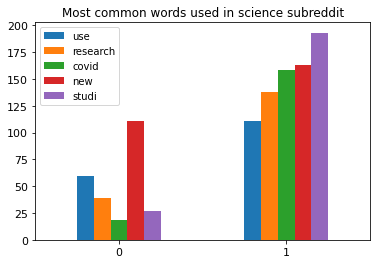

In [413]:
# Most common words used in science subreddit

top_words_science_only = (df_doc_term_matrix.iloc[:, 1:][df_doc_term_matrix['subreddit'] == 'science']
                                            .sum().sort_values(ascending = False)[:5][::-1])
                            
top_words_science_only = df_doc_term_matrix[[word for word in pd.Series(top_words_science_only).index]]

top_words_science_only.plot.bar()

plt.title('Most common words used in science subreddit')
plt.xticks(size = 11, rotation = 0)
plt.yticks(size = 11);

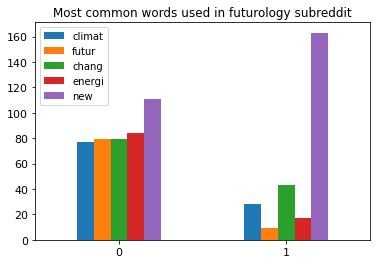

In [414]:
# Most common words used in futurology subreddit

top_words_futurology_only = (df_doc_term_matrix.iloc[:, 1:][df_doc_term_matrix['subreddit'] == 'futurology']
                                            .sum().sort_values(ascending = False)[:5][::-1])

top_words_futurology_only = df_doc_term_matrix[[word for word in pd.Series(top_words_futurology_only).index]]

top_words_futurology_only.plot.bar()

plt.title('Most common words used in futurology subreddit')
plt.xticks(size = 11, rotation = 0)
plt.yticks(size = 11);

#### Vocabulary size

In [415]:
printmd(f'**Vocabulary size by subreddit:**')
display(df_doc_term_matrix.iloc[:, 1:].sum(axis = 1))
printmd('**The vocabulary size in `futurology` is much lower than that of `science`**')

**Vocabulary size by subreddit:**

0    19767
1    29009
dtype: int64

**The vocabulary size in `futurology` is much lower than that of `science`**

#### Use of arbitrary terms one might guess are common in either subreddit

In [416]:
display(df_doc_term_matrix.groupby(by = 'subreddit')['scienc', 'scientist', 'futur', 'tech', 'technology'].sum())
printmd('**Surprisingly low..**')

,scienc,scientist,futur,tech,technology
subreddit,,,,,
futurology,7,36,79,17,1
science,12,66,9,2,0


**Surprisingly low..**

### Feature selection / Feature engineering

ref: https://en.wikipedia.org/wiki/Feature_selection

In [453]:
# Combine top words between subreddits

top_words_cols = []
top_words_cols.append([col for col in top_words.columns])
top_words_cols.append([col for col in top_words_science_only.columns])
top_words_cols.append([col for col in top_words_futurology_only.columns])

top_words_cols_new = []
for sublist in top_words_cols:
    for word in sublist:
        if word not in top_words_cols_new:
            top_words_cols_new.append(word)
        
display(top_words_cols_new)

# ref: https://stackoverflow.com/questions/952914/how-to-make-a-flat-list-out-of-list-of-lists

# Group columns (including unigrams and bigrams) containing the top words

top_words_cols_new_groups = []
all_cols = df_doc_term_matrix.columns.to_list()
top_words_cols_new

import re

for word in all_cols:
    if re.match('futur', word):
        top_words_cols_new_groups.append(word)
        
top_words_cols_new_groups[:3]        

['use',
 'covid',
 'research',
 'studi',
 'new',
 'climat',
 'futur',
 'chang',
 'energi']

['futur', 'futur abl', 'futur advanc']

In [374]:
[col for col in df_doc_term_matrix.columns if 'futur' in col]

['ahead futurist',
 'ai futur',
 'airlin futur',
 'allow futur',
 'alright futur',
 'appreci futur',
 'army futurist',
 'believ futur',
 'bet futur',
 'book futur',
 'bright futur',
 'build futurist',
 'busi futur',
 'busi futureproof',
 'car futur',
 'cashless futur',
 'chang futur',
 'compani futurist',
 'complex futureori',
 'concret futur',
 'corp futur',
 'creat futur',
 'creativ futur',
 'crispr futur',
 'current futur',
 'cybunk futur',
 'dark futur',
 'decentr futur',
 'defin futur',
 'depress futur',
 'desert futur',
 'design futur',
 'dioxid futur',
 'domin futur',
 'doug futur',
 'electron futur',
 'energi futur',
 'entir futurist',
 'envis futur',
 'explor futur',
 'farm futur',
 'fatal futur',
 'fight futur',
 'fluke futur',
 'foundat futur',
 'futur',
 'futur abl',
 'futur advanc',
 'futur ahead',
 'futur ai',
 'futur allperovskit',
 'futur analysi',
 'futur assuredli',
 'futur attractor',
 'futur autom',
 'futur automobil',
 'futur averag',
 'futur aviat',
 'futur breakt

### For fun: Niche points of interest // Pseudo topic modeling

In [371]:
# Namesake
subred[subred['title'].str.contains('plausibl utopi')]

,subreddit,title
19,futurology,kim stanley robinson on invent plausibl utopia


In [375]:
niche_list = ['abil', 'accel']

display(df_doc_term_matrix[[col for col in df_doc_term_matrix.columns if 'accel' if 'abil' in col]])

# display(df_doc_term_matrix[[col for col in df_doc_term_matrix.columns if (niche_word in col for niche_word in niche_list)]])
# https://stackoverflow.com/questions/10272898/multiple-if-conditions-in-a-python-list-comprehension/10272927

display(df_doc_term_matrix[[col for col in df_doc_term_matrix.columns if 'abil' in col]])
display(df_doc_term_matrix[[col for col in df_doc_term_matrix.columns if 'accel' in col]])
display(df_doc_term_matrix[[col for col in df_doc_term_matrix.columns if 'alien' in col]])
display(df_doc_term_matrix[[col for col in df_doc_term_matrix.columns if 'analys' in col]])
display(df_doc_term_matrix[[col for col in df_doc_term_matrix.columns if 'ancient' in col]])
display(df_doc_term_matrix[[col for col in df_doc_term_matrix.columns if 'arctic' in col]])
display(df_doc_term_matrix[[col for col in df_doc_term_matrix.columns if 'antibod' in col]])
display(df_doc_term_matrix[[col for col in df_doc_term_matrix.columns if 'apocal' in col]])
display(df_doc_term_matrix[[col for col in df_doc_term_matrix.columns if 'best' in col]])
display(df_doc_term_matrix[[col for col in df_doc_term_matrix.columns if 'better' in col]])
display(df_doc_term_matrix[[col for col in df_doc_term_matrix.columns if 'covid' in col]])
display(df_doc_term_matrix[[col for col in df_doc_term_matrix.columns if 'death' in col]])
display(df_doc_term_matrix[[col for col in df_doc_term_matrix.columns if 'digit' in col]])
display(df_doc_term_matrix[[col for col in df_doc_term_matrix.columns if 'dream' in col]])
display(df_doc_term_matrix[[col for col in df_doc_term_matrix.columns if 'dysto' in col]])
display(df_doc_term_matrix[[col for col in df_doc_term_matrix.columns if 'futur' in col]])
display(df_doc_term_matrix[[col for col in df_doc_term_matrix.columns if 'govern' in col]])
display(df_doc_term_matrix[[col for col in df_doc_term_matrix.columns if 'plaus' in col]])
display(df_doc_term_matrix[[col for col in df_doc_term_matrix.columns if 'utop' in col]])


,abil,abil absorb,abil academ,abil adapt,abil avoid,abil contract,abil control,abil current,abil evalu,abil fight,abil identifi,abil lemur,abil magnetorecept,abil maintain,abil mindcontrol,abil neuron,abil peopl,abil reiter,abil secret,abil wait,activ stability,appear stabil,arizona stabil,bind stabil,boost abil,cell viabil,cognit abil,consolid stabil,country abil,enhanc stabil,essenti abil,farmer abil,improv abil,increas abil,limit abil,loss stabil,mysteri abil,outpati rehabilit,perceiv abil,problem stabil,profession rehabilit,rehabilit,rehabilit facil,rehabilit train,said abil,shown abil,stabil,stabil analyz,stabil bestperform,stabil decreas,stabil earth,stabil ellen,stabil lock,stabil whi,stability,stability let,stiff abil,use abil,viabil,viabil assay,viru abil,wildlif abil
0,4,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,1,1,0,0,0,0,0,1
1,16,0,1,0,1,1,1,1,1,1,1,2,1,0,1,1,0,1,1,1,0,1,1,1,1,1,4,1,1,0,1,0,1,1,1,1,1,1,1,1,1,2,1,1,0,1,6,1,1,1,1,0,1,1,0,0,1,1,1,1,1,0


,abil,abil absorb,abil academ,abil adapt,abil avoid,abil contract,abil control,abil current,abil evalu,abil fight,abil identifi,abil lemur,abil magnetorecept,abil maintain,abil mindcontrol,abil neuron,abil peopl,abil reiter,abil secret,abil wait,activ stability,appear stabil,arizona stabil,bind stabil,boost abil,cell viabil,cognit abil,consolid stabil,country abil,enhanc stabil,essenti abil,farmer abil,improv abil,increas abil,limit abil,loss stabil,mysteri abil,outpati rehabilit,perceiv abil,problem stabil,profession rehabilit,rehabilit,rehabilit facil,rehabilit train,said abil,shown abil,stabil,stabil analyz,stabil bestperform,stabil decreas,stabil earth,stabil ellen,stabil lock,stabil whi,stability,stability let,stiff abil,use abil,viabil,viabil assay,viru abil,wildlif abil
0,4,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,1,1,0,0,0,0,0,1
1,16,0,1,0,1,1,1,1,1,1,1,2,1,0,1,1,0,1,1,1,0,1,1,1,1,1,4,1,1,0,1,0,1,1,1,1,1,1,1,1,1,2,1,1,0,1,6,1,1,1,1,0,1,1,0,0,1,1,1,1,1,0


,acceler,acceler autom,acceler becaus,acceler chemic,acceler coal,acceler diagnosi,acceler drug,acceler effort,acceler electr,acceler global,acceler ice,acceler structur,acceler telomer,acceler time,acceler use,acceler vistra,america acceler,biomark acceler,chang acceler,colorado acceler,cover acceler,energi acceler,gase acceler,help acceler,make acceler,melt acceler,number acceler,particl acceler,promis acceler,type acceler,way acceler
0,9,1,1,0,1,0,0,0,1,1,0,1,0,1,1,1,1,0,1,1,1,2,0,0,1,0,0,1,0,1,0
1,7,0,0,1,0,1,1,2,0,0,1,0,1,0,0,0,0,1,0,0,0,0,1,1,0,1,1,0,1,0,1


,advanc alien,alien,alien civil,alien life,alien like,alien nonn,alien speci,alien technolog,alien world,earth alien,evid alien,listen alien,number alien,search alien,water alien
0,0,4,1,1,1,0,0,0,1,1,0,1,0,1,1
1,1,4,1,0,0,1,1,1,0,0,1,0,2,0,0


,analys,analys dissert,analys facial,analys global,analys latrin,analys specif,analysi,analysi brainboost,analysi canadian,analysi china,analysi clinic,analysi combin,analysi data,analysi deepfak,analysi evolut,analysi global,analysi indic,analysi literatur,analysi lower,analysi million,analysi millionyearold,analysi modern,analysi myalgic,analysi onefifth,analysi registri,analysi reveal,analysi robust,analysi sleep,analysi steakumm,analysi team,analysi thi,analysi trauma,analysi trump,analysi wa,analyst,analyst launch,analyst said,ape analysi,arrest analysi,belgium analysi,bodi analysi,causedelet analysi,collaps analysi,comprehens analysi,corpu analysi,decad analysi,disord metaanalysi,effect analysi,energi analyst,futur analysi,genet analysi,ha metaanalysi,jargon analys,learn analys,metaanalysi,metaanalysi drug,metaanalysi studi,metaanalysi thirti,metagenom analys,misinform analysi,multispectr analysi,nanocellulos analysi,network analysi,network metaanalysi,peerreview analysi,pinpoint analys,pioneer analysi,regress analys,reus analysi,reveal analysi,reward analysi,statist analysi,studi analysi,swathm analysi,trajectori analyst,univ analysi,week analysi
0,0,0,0,0,0,0,4,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,2,1,1,0,0,0,0,0,1,0,0,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0
1,5,1,1,1,1,1,24,1,1,0,1,1,1,0,1,0,1,1,1,2,1,1,1,0,1,1,1,1,1,1,1,1,1,1,0,0,0,1,1,1,1,1,0,1,1,0,1,1,0,0,2,1,1,1,3,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1,1


,ancient,ancient ancestor,ancient black,ancient dna,ancient eleph,ancient impact,ancient lake,ancient leather,ancient megalodon,ancient parasit,ancient period,ancient persia,ancient underwat,entangl ancient,footprint ancient,fossil ancient,hygien ancient,import ancient,investig ancient,light ancient,massiv ancient,occur ancient,studi ancient,theori ancient,wa ancient
0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
1,11,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1,1,1,1,1,1,1


,ai antarctica,antarctica,antarctica alon,antarctica ice,antarctica melt,antarctica studi,antarctica suggest,antarctica whale,arctic,arctic circl,arctic climat,arctic ha,arctic hasn,arctic ocean,arctic sea,arctic shift,arctic suggest,chang arctic,discov arctic,eastern arctic,greenland antarctica,imposs arctic,instead arctic,just antarctica,penguin antarctica,rise arctic,russian arctic,soil arctic,whale antarctica,whale arctic
0,1,1,0,0,1,0,0,0,5,1,1,0,1,1,0,0,1,1,1,0,0,0,1,0,0,1,0,1,0,0
1,0,5,1,1,0,1,1,1,4,0,0,1,0,1,1,1,0,0,0,1,1,1,0,1,1,0,1,0,2,1


,abund antibodi,adult antibodi,antibodi,antibodi attack,antibodi bind,antibodi compar,antibodi compon,antibodi cough,antibodi diagnos,antibodi discoveri,antibodi level,antibodi profil,antibodi protect,antibodi sarscov,antibodi serum,antibodi test,antibodi viru,autoantibodi,autoantibodi type,becaus antibodi,bind neutralizingantibodi,fewer antibodi,form antibodi,igg antibodi,make antibodi,model autoantibodi,mutat antibodi,neutralizingantibodi,neutralizingantibodi titer,new antibodi,plume antibodi,sarscov antibodi,serum antibodi,standard antibodi,tini antibodi,virusspecif antibodi
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,1,17,1,1,1,1,1,1,1,1,1,1,2,1,3,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,3,1,1,1,1


,apocalyps,apocalyps extrapol,gentl apocalyps
0,1,1,1
1,0,0,0


,appli best,asbesto,asbesto power,best,best estim,best friend,best global,best guess,best hope,best option,best recommend,bestperform,bestperform formul,chang asbesto,distract best,level best,need best,say best,scientist best,stabil bestperform,vehicl best
0,1,1,1,4,0,0,1,1,1,1,0,0,0,1,1,1,0,0,0,0,1
1,0,0,0,3,1,1,0,0,0,0,1,1,1,0,0,0,1,1,1,1,0


,allow better,associ better,better,better access,better align,better ani,better bring,better calcul,better children,better colonis,better cut,better earth,better given,better guid,better human,better hydrogen,better life,better neg,better norm,better obes,better partial,better person,better placebo,better rehab,better school,better sham,better solar,better structur,better subject,better unit,better wellb,better work,build better,clearli better,condit better,countri better,dog better,extrem better,far better,grew better,help better,learn better,nanolay better,outbreak better,parent better,perform better,planet better,poverti better,preschool better,print better,react better,recov better,similar better,skill better,someth better,surgeri better,thing better
0,0,0,12,1,0,0,0,0,0,0,1,1,0,1,1,1,1,0,1,0,1,1,0,0,0,0,1,0,0,1,0,0,1,1,0,1,1,0,0,1,1,0,1,0,0,0,2,0,0,1,0,0,1,0,1,0,0
1,1,1,20,0,1,2,1,1,1,1,0,1,1,0,0,0,1,1,0,1,0,0,1,1,1,1,0,1,1,0,1,1,0,0,1,0,0,1,1,0,0,1,0,1,1,2,1,1,1,0,1,1,0,1,0,2,2


,acquir covid,admiss covid,affect covid,age covid,alexa covid,amid covid,appear covid,associ covid,attribut covid,befor covid,biodivers covid,brandvoic covid,burden covid,case covid,caus covid,center covid,chang covid,children covid,cohort covid,context covid,convers covid,counter covid,covid,covid accur,covid american,covid associ,covid basic,covid cardiac,covid case,covid caus,covid child,covid children,covid clinic,covid conceptu,covid conspiraci,covid construct,covid contact,covid coronaviru,covid corticosteroid,covid creat,covid crisi,covid death,...,postcovid dopamin,postcovid encycl,postcovid era,prebunks covid,predict covid,predictor covid,prevent covid,rate covid,ravag covid,recovery covid,reduc covid,reinfect covid,relat covid,remedi covid,replic covid,research covid,respond covid,respons covid,rise covid,risk covid,sarscov covid,sarscov covidnudg,seriou covid,sever covid,silent covid,sinc covid,smell covid,sourc covid,spread covid,state covid,struggl covid,studi covid,symptom covid,synerg covid,thi covid,treat covid,treatment covid,trial covid,trust covid,vaccin covid,wave covid,whi covid
0,0,0,0,0,1,1,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,18,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,...,0,1,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0
1,1,1,1,1,0,0,1,2,1,1,0,0,1,1,4,1,1,2,1,1,1,1,158,1,1,1,1,1,8,1,1,1,1,1,3,0,1,2,1,0,0,3,...,1,0,0,1,1,1,2,1,0,0,2,1,1,1,1,1,1,1,2,1,1,1,1,9,1,0,1,1,7,1,1,2,1,1,0,1,3,1,1,0,1,1


,bring death,care death,caus death,contribut death,coronaviru death,covid death,death,death associ,death attribut,death capita,death caus,death celebr,death citi,death code,death disabl,death dog,death flu,death help,death older,death phone,death pollut,death prevent,death rate,death understand,deathbig,deathbig bang,everi death,exampl death,excess death,global death,heat deathbig,ill death,number death,peak death,vessel death,wast death
0,0,0,0,0,0,0,2,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0,0,1,0,0,0,0,1
1,1,1,1,1,1,3,15,1,1,1,1,0,0,1,1,1,1,1,1,1,1,1,1,1,0,0,1,0,1,1,0,1,1,1,1,0


,activefeedback digit,cancer digit,checkout digit,compani digit,currenc digit,digit,digit age,digit asset,digit bit,digit book,digit data,digit deploy,digit dream,digit patholog,digit piecework,digit stroke,digit technolog,digit world,head digit,new digit,planet digit,power digit,robot digit,total digit,utopian digit
0,0,1,1,1,1,10,1,1,1,1,1,1,1,0,1,0,1,1,1,0,1,1,1,1,1
1,1,0,0,0,0,2,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0


,daydream,daydream actual,digit dream,dream,dream accord,dream cluster,dream develop,dream dream,dream dystopian,dream form,dream guid,dream hybrid,dream imageri,dream neg,dream realiti,dream use,dreamshap,dreamshap tech,echo dream,guid dream,heighten dream,make dream,men dream,peopl dream,plasma dreamshap,profess daydream,real dreamshap,suggest dream,theme dream,women dream
0,0,0,1,6,0,0,1,0,1,0,1,1,0,0,1,1,2,2,0,1,0,1,0,0,1,0,1,2,1,0
1,1,1,0,6,1,1,0,1,0,1,0,0,1,1,0,0,0,0,1,0,1,0,1,1,0,1,0,0,0,1


,dream dystopian,dystopian,dystopian inequ
0,1,1,1
1,0,0,0


,ahead futurist,ai futur,airlin futur,allow futur,alright futur,appreci futur,army futurist,believ futur,bet futur,book futur,bright futur,build futurist,busi futur,busi futureproof,car futur,cashless futur,chang futur,compani futurist,complex futureori,concret futur,corp futur,creat futur,creativ futur,crispr futur,current futur,cybunk futur,dark futur,decentr futur,defin futur,depress futur,desert futur,design futur,dioxid futur,domin futur,doug futur,electron futur,energi futur,entir futurist,envis futur,explor futur,farm futur,fatal futur,...,misinform futur,money futurist,moon futur,musk futurist,near futur,nobodi rfuturolog,perciev futur,plan futur,platform futurolog,power futur,predict futur,prepar futur,present futur,propel futur,realiti futur,reclaim futurolog,regener futur,repair futur,resid futur,reveal futurecraft,rfuturolog,rfuturolog saw,robocab futur,second futur,selfsuffici futur,shape futur,softwar futur,subject futur,superbatteri futur,sustain futur,technolog futur,tesla futur,thi futur,think futurist,travel futur,undoubtedli futur,unstabl futur,use futur,vision futur,work futur,world futur,year futur
0,1,1,1,1,1,1,1,0,1,1,1,1,1,1,1,1,2,1,1,1,1,1,1,1,0,1,1,1,1,0,1,1,1,1,1,0,2,1,1,1,1,1,...,0,1,1,1,1,1,1,1,1,1,2,1,1,1,1,1,1,1,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,2
1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


,ai govern,cc govern,coronaviru govern,french govern,global govern,globe govern,govern,govern bodi,govern describ,govern evid,govern geograph,govern ha,govern implement,govern offici,govern recoup,govern seiz,govern sourc,govern step,govern strategi,govern technologist,govern world,government,government fight,government promis,governor,governor il,governor slower,head govern,help govern,network govern,plan government,politician govern,provid govern,punish govern,republican governor,satisfact govern,state governor,themselv govern,uk government
0,1,1,0,1,1,1,7,0,0,0,0,1,0,1,0,1,0,1,1,1,1,1,0,1,0,0,0,0,1,0,1,1,0,0,0,0,0,0,0
1,0,0,1,0,0,0,7,1,1,1,1,0,1,0,1,0,1,0,0,0,0,1,1,0,2,1,1,1,0,1,0,0,1,1,1,1,1,1,1


,invent plausibl,plausibl,plausibl fukushima,plausibl utopia,travel plausibl
0,1,2,1,1,1
1,0,0,0,0,0


,ahead utopian,plausibl utopia,utopia,utopia anatomi,utopian,utopian digit
0,1,1,1,1,1,1
1,0,0,0,0,0,0


In [330]:
display(pd.set_option('display.max_colwidth', 200), df_doc_term_matrix.iloc[:, 2200:2300])

None

,berkeley,berkeley work,berlin,berlin pari,best,best estim,best friend,best global,best guess,best hope,best option,best recommend,bestperform,bestperform formul,bet,bet futur,bet vertic,bet wind,betacel,betacel pancrea,betray,betray wa,better,better access,better align,better ani,better bring,better calcul,better children,better colonis,better cut,better earth,better given,better guid,better human,better hydrogen,better life,better neg,better norm,better obes,better partial,better person,...,bi,bi billion,bia,bia appear,bia gpt,bia judgment,bia neg,bia reveal,bia time,bia twitter,bia work,bias,bias exam,bicycl,bicycl ha,biden,biden gender,bidirect,bidirect bia,big,big action,big bang,big bet,big chang,big citi,big consequ,big fish,big idea,big legal,big lie,big philosoph,big pond,big way,bigbudget,bigbudget product,bigger,bigger sir,biggest,biggest compani,biggest competitor,biggest equiti,biggest hybrid
0,1,1,1,1,4,0,0,1,1,1,1,0,0,0,3,1,1,1,0,0,0,0,12,1,0,0,0,0,0,0,1,1,0,1,1,1,1,0,1,0,1,1,...,0,0,2,0,1,0,0,0,0,1,0,1,1,1,1,0,0,0,0,9,1,1,1,1,1,1,0,1,1,1,0,0,0,1,1,1,1,8,1,1,1,1
1,0,0,0,0,3,1,1,0,0,0,0,1,1,1,0,0,0,0,1,1,1,1,20,0,1,2,1,1,1,1,0,1,1,0,0,0,1,1,0,1,0,0,...,1,1,6,1,0,1,1,1,1,0,1,0,0,0,0,1,1,1,1,7,0,3,0,0,0,0,1,0,0,0,1,1,1,0,0,0,0,1,0,0,0,0


In [217]:

def get_top_words_post(row):
    for word in top_words_all:
        if row.str.contains(word, regex = True) == True:
            return subred[row]

subred['title'].apply(lambda x: get_top_words_post(x))

AttributeError: 'str' object has no attribute 'str'

In [261]:
top_words_all = ['climat', 'chang', 'futur', 'energi' 'new', 'use', 'research', 'covid', 'study']

import re

subred[subred['title'].str.contains('climat', regex = True)]

,subreddit,title
14,futurology,climat chang is acceler becaus of rich consumers’ energi use “highli affluent consum drive biophys resourc use a directli through high consumpt b as member of power faction of the capitalist class and c through drive consumpt norm across the population”
16,futurology,new studi cast doubt on the climat benefit of natur ga power plant the emiss and methan leak from new ga plant zero out the co cut achiev from close coal plant a peerreview analysi found
22,futurology,climat chang megathread
67,futurology,climat chang a factor in most of the natur disast over last year un report
115,futurology,whi climat chang is a time bomb
191,futurology,a farewel to ice fish climat chang lead to less lake ice as the world warm winter on grand travers bay — and mani other lake — arent what they use to be the bay recent had two icefre year in a row
211,futurology,climat chang and poor plan are blame for california blackout
231,futurology,idea to save the planet with controversi geoengin geoengineering—a technolog approach to tackl climat change—i either a danger distract or our best hope depend on whom you ask
241,futurology,climat chang ha a cow and worm problem methan is to time more power than carbon dioxid when it come to heat up the planet when parasit worm infect are taken into consider the increas in methan could jump as high as percent
283,futurology,asbesto could be a power weapon against climat chang you read that right scientist are explor way to use miner wast from mine to pull huge amount of carbon dioxid out of the air


In [262]:
df_doc_term_matrix['subreddit'] = df_doc_term_matrix['subreddit'].map({'science': 1, 'futurology': 0})

df_doc_term_matrix.sum().sort_values(ascending = False)[:20]

new          274
studi        220
research     177
covid        176
use          170
chang        122
ha           118
peopl        110
time         106
climat       105
thi          102
scientist    102
energi       101
human         96
world         95
like          91
year          90
futur         88
cell          75
solar         74
dtype: int64

In [263]:
# Instantiate CountVectorizer 
cvec = CountVectorizer(stop_words = 'english')

# Fit and transform the vectorizer on the corpus
X = cvec.fit_transform(X)

printmd('**Size of feature matrix:**')
display(X.shape)

printmd(f'**Count of tokens:** {len(cvec.get_feature_names())}')

printmd('**Have a look at random slices of our tokens:**')
for i in np.arange(0, len(cvec.get_feature_names()), step = 1_000):
    increment = 20
    print('\n', cvec.get_feature_names()[i: i + increment])

**Size of feature matrix:**

(1800, 5671)

**Count of tokens:** 5671

**Have a look at random slices of our tokens:**


 ['aalto', 'abandon', 'abdomen', 'aberdeen', 'aberr', 'abil', 'abl', 'abnorm', 'aboard', 'abolish', 'abov', 'aboveaverag', 'abras', 'absenc', 'absolut', 'absorb', 'abstract', 'abund', 'abus', 'academ']

 ['condemn', 'condens', 'condit', 'conditionerlik', 'conduct', 'confer', 'confid', 'configur', 'confin', 'confirm', 'conflict', 'conform', 'confront', 'confus', 'congo', 'congreg', 'congress', 'connect', 'conscienc', 'conscienti']

 ['fuelcel', 'fueleffici', 'fukushima', 'fulfil', 'fulli', 'fulltext', 'fun', 'function', 'fund', 'fundament', 'funni', 'furnac', 'fusion', 'futur', 'futurecraft', 'futureori', 'futureproof', 'futurist', 'futurolog', 'ga']

 ['manifold', 'manipul', 'mankind', 'manmad', 'manner', 'manoeuvr', 'mantl', 'manufactur', 'manur', 'map', 'mar', 'march', 'marek', 'maresin', 'margin', 'marijuana', 'marin', 'maritim', 'mark', 'marker']

 ['prolifer', 'promis', 'promot', 'prompt', 'proof', 'proofofconcept', 'propaganda', 'propel', 'properly', 'properti', 'property', 'pro

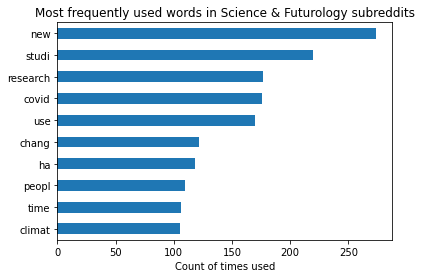

In [264]:
# Convert training data to dataframe
X = pd.DataFrame(X.todense(), columns = cvec.get_feature_names())

# Plot top occurring words
X.sum().sort_values(ascending = False).head(10)[::-1].plot(kind = 'barh')

plt.title('Most frequently used words in Science & Futurology subreddits')
plt.xlabel('Count of times used');

<br>

### Bag of Words analysis

#### TfidfVectorizer

The TF-IDF score indicates which words are important to a document, relative to all other documents.

Words that occur often in one document but don't occur in many documents contain more predictive power.

#### Create a document-term matrix to match up the subreddits and words

In [265]:
subred['title'] = subred['title'].apply(split_and_lemmatize)

subred_grouped_by_sub = subred[['subreddit', 'title']].groupby(by = 'subreddit').agg(lambda x: ' '.join(x))

# Create a document-term matrix

# Build a vocabulary that weights words on their importance to the corpus relative to the other documents in the corpus

tvec = TfidfVectorizer(max_features = 6_000,            # Limit words to those with a term frequency of 6,000 
                       stop_words = 'english',          # English stopwords
                       ngram_range = (1, 2)             # unigrams and bigrams
                      ) 

subred_grouped_by_sub_tvec = tvec.fit_transform(subred_grouped_by_sub['title'])

df_doc_term_matrix_tvec = pd.DataFrame(subred_grouped_by_sub_tvec.todense(), columns = tvec.get_feature_names())

df_doc_term_matrix_tvec['subreddit'] = subred_grouped_by_sub.index
subreddit_col = df_doc_term_matrix_tvec.pop('subreddit')
df_doc_term_matrix_tvec.insert(0, 'subreddit', subreddit_col)

display(df_doc_term_matrix)
df_doc_term_matrix_tvec

# ref: https://www.analyticsvidhya.com/blog/2020/04/beginners-guide-exploratory-data-analysis-text-data/

,subreddit,aalto,aalto univers,abandon,abandon invest,abdomen,abdomen larg,aberdeen,aberdeen citi,aberdeen develop,aberr,aberr synapt,abil,abil absorb,abil academ,abil adapt,abil avoid,abil contract,abil control,abil current,abil evalu,abil fight,abil identifi,abil lemur,abil magnetorecept,abil maintain,abil mindcontrol,abil neuron,abil peopl,abil reiter,abil secret,abil wait,abl,abl attribut,abl chang,abl follow,abl hangout,abl hit,abl just,abl make,abl rewir,abnorm,...,zero,zero carbon,zero cut,zero economi,zero emiss,zero plastic,zeroavia,zeroavia complet,zeroavia conduct,zeroavia retrofit,zerocarbon,zerocarbon hous,zeroemiss,zeroemiss concept,zeroemiss flight,zeroemiss fuel,zinc,zinc zn,zip,zip code,zip star,ziplin,ziplin unit,zircon,zircon hyperson,zn,zn base,zombi,zombi fires,zombi occur,zombi storm,zone,zone estuari,zoologist,zoologist uncov,zoom,zoom algorithm,zoom lapd,αcmₚmₑ½,αcmₚmₑ½ km,μg,μg dose
0,0,0,0,1,1,0,0,2,1,1,0,0,4,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,5,1,0,1,1,1,1,0,0,0,...,5,2,1,1,1,0,3,1,1,1,1,1,3,1,1,1,1,1,0,0,0,1,1,1,1,1,1,4,1,1,2,1,1,0,0,2,1,1,0,0,0,0
1,1,1,1,0,0,1,1,0,0,0,1,1,16,0,1,0,1,1,1,1,1,1,1,2,1,0,1,1,0,1,1,1,3,0,1,0,0,0,0,1,1,3,...,2,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,2,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,1,2,2


,subreddit,aberdeen,abil,abil lemur,abl,abnorm,abov,absolut,absorb,abstract,abstract acronym,abund,abus,academ,academi,academi scienc,acceler,acceler effort,accept,access,accommod,accord,accord major,accord new,accord research,accord studi,account,accur,accur predict,accuraci,ace,achiev,achiev close,acid,acoust,acquir,acronym,act,act like,act realiti,action,activ,...,worri,wors,worst,worth,wound,write,wrong,xpeng,xray,year,year ago,year amazon,year compar,year despit,year follow,year futur,year old,year report,year studi,yearold,yearold human,yield,york,young,young adult,younger,youth,youtub,zebrafish,zeolit,zeolit membran,zero,zero carbon,zero cut,zeroavia,zeroemiss,zip,zombi,zombi storm,zoom,μg,μg dose
0,futurology,0.006774,0.009640,0.000000,0.012050,0.000000,0.000000,0.002410,0.002410,0.000000,0.000000,0.002410,0.000000,0.000000,0.002410,0.002410,0.021689,0.000000,0.002410,0.012050,0.006774,0.014459,0.000000,0.004820,0.000000,0.000000,0.009640,0.007230,0.006774,0.000000,0.000000,0.009640,0.002410,0.000000,0.004820,0.000000,0.000000,0.014459,0.007230,0.002410,0.014459,0.012050,...,0.004820,0.004820,0.013548,0.009640,0.000000,0.006774,0.000000,0.006774,0.000000,0.118085,0.012050,0.006774,0.006774,0.002410,0.000000,0.006774,0.000000,0.006774,0.002410,0.004820,0.000000,0.002410,0.002410,0.004820,0.000000,0.000000,0.000000,0.002410,0.002410,0.002410,0.002410,0.012050,0.006774,0.002410,0.010161,0.010161,0.000000,0.013548,0.006774,0.006774,0.000000,0.000000
1,science,0.000000,0.027992,0.004918,0.005248,0.007376,0.009835,0.001749,0.001749,0.007376,0.004918,0.003499,0.004918,0.007376,0.001749,0.001749,0.012246,0.004918,0.003499,0.010497,0.000000,0.057733,0.004918,0.029741,0.007376,0.019671,0.012246,0.001749,0.000000,0.004918,0.004918,0.010497,0.001749,0.022129,0.001749,0.004918,0.009835,0.012246,0.003499,0.001749,0.010497,0.045486,...,0.001749,0.005248,0.000000,0.001749,0.004918,0.000000,0.007376,0.000000,0.009835,0.071729,0.010497,0.000000,0.000000,0.001749,0.007376,0.000000,0.012294,0.000000,0.003499,0.013996,0.004918,0.005248,0.003499,0.017495,0.012294,0.007376,0.004918,0.001749,0.001749,0.001749,0.001749,0.003499,0.000000,0.001749,0.000000,0.000000,0.004918,0.000000,0.000000,0.000000,0.004918,0.004918
